           CRIM          ZN      INDUS      CHAS       NOX        RM  \
mean   3.611874   11.211934  11.083992  0.069959  0.554695  6.284634   
std    8.720192   23.388876   6.835896  0.255340  0.115878  0.702617   
min    0.006320    0.000000   0.460000  0.000000  0.385000  3.561000   
max   88.976200  100.000000  27.740000  1.000000  0.871000  8.780000   

             AGE        DIS        RAD         TAX    PTRATIO           B  \
mean   68.518519   3.795043   9.549407  408.237154  18.455534  356.674032   
std    27.999513   2.105710   8.707259  168.537116   2.164946   91.294864   
min     2.900000   1.129600   1.000000  187.000000  12.600000    0.320000   
max   100.000000  12.126500  24.000000  711.000000  22.000000  396.900000   

          LSTAT       MEDV  
mean  12.715432  22.532806  
std    7.155871   9.197104  
min    1.730000   5.000000  
max   37.970000  50.000000  


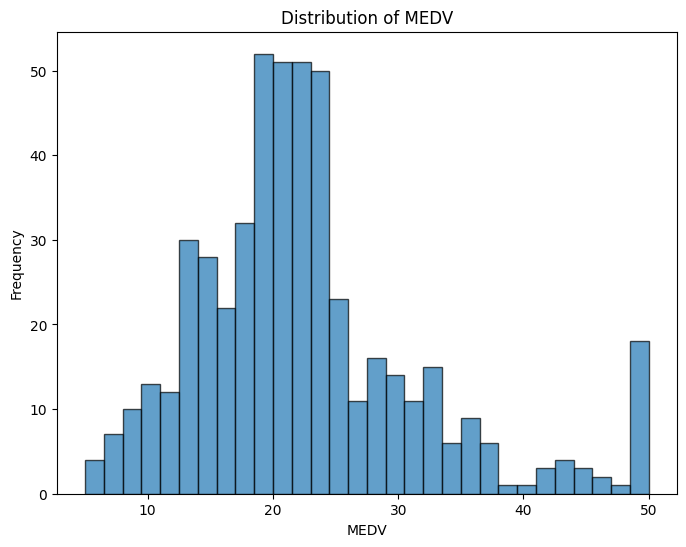

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Load the dataset and display basic statistics
housing_data = pd.read_csv("../../data/external/HousingData.csv")
stats_summary = housing_data.agg(['mean', 'std', 'min', 'max'])
print(stats_summary)

# Plot the distribution of the target variable (MEDV)
medv_values = housing_data['MEDV']

plt.figure(figsize=(8, 6))
plt.hist(medv_values, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.title('Distribution of MEDV')
plt.savefig('figures/3/MEDV_distribution.png')
plt.show()

# Split the dataset into training (70%), validation (15%), and test (15%) sets
features = housing_data.drop(columns=['MEDV'])
target = housing_data['MEDV']
target = np.array(target).reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Normalize the features using Min-Max scaling
min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(X_train_imputed)
X_val_normalized = min_max_scaler.transform(X_val_imputed)
X_test_normalized = min_max_scaler.transform(X_test_imputed)

# Standardize the features to have mean=0 and std=1 using Z-score scaling
standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train_imputed)
X_val_standardized = standard_scaler.transform(X_val_imputed)
X_test_standardized = standard_scaler.transform(X_test_imputed)



In [3]:
import numpy as np

class MLPRegressor:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', 
                 learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd', patience=5, min_delta=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.patience = patience
        self.min_delta = min_delta

        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

        self.set_activation(activation)

    def set_activation(self, activation):
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        elif activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == 'linear':
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative
        else:
            raise ValueError("Unsupported activation function")

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -709, 709)))

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def linear_derivative(x):
        return np.ones_like(x)

    def forward_propagation(self, X):
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activation(z) if i < len(self.weights) - 1 else z
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y):
        m = X.shape[0]
        delta = self.layer_outputs[-1] - y.reshape(-1, 1)
        gradients = []
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dW, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(self.layer_outputs[i])
        return list(reversed(gradients))

    def update_parameters(self, gradients):
        for i, (dW, db) in enumerate(gradients):
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, X_val=None, y_val=None):
        self.losses = []
        self.val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                y_pred = self.forward_propagation(batch_X)
                gradients = self.backward_propagation(batch_X, batch_y)
                self.update_parameters(gradients)
            
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val)
                self.val_losses.append(val_loss)
                
                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward_propagation(X)

    def compute_loss(self, X, y):
        y_pred = self.forward_propagation(X)
        return np.mean((y_pred - y.reshape(-1, 1))**2)

    def gradient_checking(self, X, y, epsilon=1e-7):
        gradients = self.backward_propagation(X, y)
        for i, (dW, db) in enumerate(gradients):
            for j in range(dW.shape[0]):
                for k in range(dW.shape[1]):
                    self.weights[i][j, k] += epsilon
                    cost_plus = self.compute_loss(X, y)
                    self.weights[i][j, k] -= 2 * epsilon
                    cost_minus = self.compute_loss(X, y)
                    self.weights[i][j, k] += epsilon
                    
                    grad_approx = (cost_plus - cost_minus) / (2 * epsilon)
                    grad_backprop = dW[j, k]
                    
                    rel_error = abs(grad_backprop - grad_approx) / max(abs(grad_backprop), abs(grad_approx))
                    if rel_error > 1e-5:
                        print(f"Gradient Check Failed for W[{i}][{j},{k}]. Relative Error: {rel_error:.6f}")
                        return False
        
        print("Gradient Check Passed!")
        return True
    


import wandb
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = MLPRegressor(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        output_size=1,
        activation=config['activation'],
        learning_rate=config['learning_rate'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        optimizer=config['optimizer']
    )
    
    model.fit(X_train, y_train, X_val, y_val)
    
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    return model, mse, rmse, r2

def hyperparameter_tuning(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test):
    # Define hyperparameters to tune
    hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
    activations = ['sigmoid', 'tanh', 'relu']
    learning_rates = [0.0001, 0.001, 0.01]
    epochs_list = [100, 500, 1000]
    batch_sizes = [16, 32, 64]
    optimizers = ['sgd', 'batch', 'mini-batch']

    best_model = None
    best_mse = float('inf')
    best_config = None

    wandb.init(project='regression_test_prefinal', entity='vishnuvarun-iiit-hyderabad')

    for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
        config = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size,
            'optimizer': optimizer
        }
        
        print(f"Testing configuration: {config}")
        
        model, mse, rmse, r2 = train_and_evaluate(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test, config)
        
        wandb.log({
            "mse": mse,
            "rmse": rmse,
            "r2_score": r2
        })
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_config = config

    print("Best Model Configuration:")
    print(best_config)
    wandb.finish()
    return best_model

# Perform hyperparameter tuning
best_model = hyperparameter_tuning(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test)

Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Epoch 100/100, Loss: 77.4661
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Epoch 100/100, Loss: 68.5489
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Epoch 100/100, Loss: 73.7671
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}
Epoch 100/100, Loss: 86.4225
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Epoch 100/100, Loss: 83.1795
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'lea

mse,▃▁▂▁▁▅█▄▃▁▂▄▂▁▁▁▄▃▂▄▅▅▃▇▂▁▁▁▁▂▂▃▁▁▁▃▁▂▁▁
r2_score,▁▇███▅▁▅▂▃▂▄▁▁▁████▄█▇█▇▅███▆█▇▇▆▇█▇▇███
rmse,▃▃▂▃▁▁█▄▃▄▅▁▁▁▁▁▁▂▂▁▃▇▃▁▁▂▃▃▂▁▂▁▃▂▂▁▁▁▁▃
mse,20.05143
r2_score,0.74772
rmse,4.47788


In [4]:
# Best Model Configuration:
# {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
import numpy as np

class MLPRegressor:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', 
                 learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd', patience=5, min_delta=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.patience = patience
        self.min_delta = min_delta

        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

        self.set_activation(activation)

    def set_activation(self, activation):
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        elif activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == 'linear':
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative
        else:
            raise ValueError("Unsupported activation function")

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -709, 709)))

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def linear_derivative(x):
        return np.ones_like(x)

    def forward_propagation(self, X):
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activation(z) if i < len(self.weights) - 1 else z
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y):
        m = X.shape[0]
        delta = self.layer_outputs[-1] - y.reshape(-1, 1)
        gradients = []
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dW, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(self.layer_outputs[i])
        return list(reversed(gradients))

    def update_parameters(self, gradients):
        for i, (dW, db) in enumerate(gradients):
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, X_val=None, y_val=None):
        self.losses = []
        self.val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                y_pred = self.forward_propagation(batch_X)
                gradients = self.backward_propagation(batch_X, batch_y)
                self.update_parameters(gradients)
            
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val)
                self.val_losses.append(val_loss)
                
                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward_propagation(X)

    def compute_loss(self, X, y):
        y_pred = self.forward_propagation(X)
        return np.mean((y_pred - y.reshape(-1, 1))**2)

    def gradient_checking(self, X, y, epsilon=1e-7):
        gradients = self.backward_propagation(X, y)
        for i, (dW, db) in enumerate(gradients):
            for j in range(dW.shape[0]):
                for k in range(dW.shape[1]):
                    self.weights[i][j, k] += epsilon
                    cost_plus = self.compute_loss(X, y)
                    self.weights[i][j, k] -= 2 * epsilon
                    cost_minus = self.compute_loss(X, y)
                    self.weights[i][j, k] += epsilon
                    
                    grad_approx = (cost_plus - cost_minus) / (2 * epsilon)
                    grad_backprop = dW[j, k]
                    
                    rel_error = abs(grad_backprop - grad_approx) / max(abs(grad_backprop), abs(grad_approx))
                    if rel_error > 1e-5:
                        print(f"Gradient Check Failed for W[{i}][{j},{k}]. Relative Error: {rel_error:.6f}")
                        return False
        
        print("Gradient Check Passed!")
        return True
    


import wandb
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = MLPRegressor(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        output_size=1,
        activation=config['activation'],
        learning_rate=config['learning_rate'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        optimizer=config['optimizer']
    )
    
    model.fit(X_train, y_train, X_val, y_val)
    
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    return model, mse, rmse, r2

def hyperparameter_tuning(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test):
    # Define hyperparameters to tune
    hidden_sizes_list = [[64, 32]]
    activations = ['sigmoid']
    learning_rates = [0.01]
    epochs_list = [1000]
    batch_sizes = [16]
    optimizers = ['batch']

    best_model = None
    best_mse = float('inf')
    best_config = None

    wandb.init(project='regression_test_prefinal_best', entity='vishnuvarun-iiit-hyderabad')

    for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
        config = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size,
            'optimizer': optimizer
        }
        
        print(f"Testing configuration: {config}")
        
        model, mse, rmse, r2 = train_and_evaluate(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test, config)
        
        wandb.log({
            "mse": mse,
            "rmse": rmse,
            "r2_score": r2
        })
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_config = config

    print("Best Model Configuration:")
    print(best_config)
    wandb.finish()
    return best_model

# Perform hyperparameter tuning
best_model = hyperparameter_tuning(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vishnuvarun (vishnuvarun-iiit-hyderabad). Use `wandb login --relogin` to force relogin


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Epoch 100/1000, Loss: 7.3085
Epoch 200/1000, Loss: 5.0206
Epoch 300/1000, Loss: 4.1276
Early stopping at epoch 315
Best Model Configuration:
{'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


mse,▁
r2_score,▁
rmse,▁
mse,14.46291
r2_score,0.81803
rmse,3.80301


In [9]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# def evaluate_best_model(X_test, y_test, best_model):
#     print("Best Model Parameters:")
#     print(f"Hidden Sizes: {best_model.hidden_sizes}")
#     print(f"Activation Function: {best_model.activation}")
#     print(f"Learning Rate: {best_model.learning_rate}")
#     print(f"Optimizer: {best_model.optimizer}")
#     print(f"Batch Size: {best_model.batch_size}")
#     print(f"Number of Epochs: {best_model.epochs}")
    
    
#     y_pred = best_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     print("\nTest Set Metrics:")
#     print(f"Test MSE: {mse:.4f}")
#     print(f"Test MAE: {mae:.4f}")


# # Evaluate the best model
# evaluate_best_model(X_test_standardized, y_test, best_model)

import numpy as np

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def evaluate_best_model(X_test, y_test, X_val, y_val, best_model):
    print("Best Model Parameters:")
    print(f"Hidden Sizes: {best_model.hidden_sizes}")
    print(f"Activation Function: {best_model.activation}")
    print(f"Learning Rate: {best_model.learning_rate}")
    print(f"Optimizer: {best_model.optimizer}")
    print(f"Batch Size: {best_model.batch_size}")
    print(f"Number of Epochs: {best_model.epochs}")
    
    # Evaluate on validation set
    y_pred_val = best_model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    rmse_val = root_mean_squared_error(y_val, y_pred_val)
    r2_val = r_squared(y_val, y_pred_val)
    
    print("\nValidation Set Metrics:")
    print(f"Validation MSE: {mse_val:.4f}")
    print(f"Validation MAE: {mae_val:.4f}")
    print(f"Validation RMSE: {rmse_val:.4f}")
    print(f"Validation R-squared: {r2_val:.4f}")
    
    # Evaluate on test set
    y_pred_test = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    r2_test = r_squared(y_test, y_pred_test)
    
    print("\nTest Set Metrics:")
    print(f"Test MSE: {mse_test:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test RMSE: {rmse_test:.4f}")
    print(f"Test R-squared: {r2_test:.4f}")

# Evaluate the best model
evaluate_best_model(X_test_standardized, y_test, X_val_standardized, y_val, best_model)

Best Model Parameters:
Hidden Sizes: [64, 32]
Activation Function: <function MLPRegressor.sigmoid at 0x7f3f2de3f4c0>
Learning Rate: 0.01
Optimizer: batch
Batch Size: 16
Number of Epochs: 1000

Validation Set Metrics:
Validation MSE: 5.5323
Validation MAE: 1.7457
Validation RMSE: 2.3521
Validation R-squared: 0.9202

Test Set Metrics:
Test MSE: 14.4629
Test MAE: 2.1931
Test RMSE: 3.8030
Test R-squared: 0.8180


Top 5 data points with the highest MSE:
    Index         MSE    True             Predicted
2       2  488.918032  [50.0]  [27.888509040623738]
20     20  123.138755  [36.2]  [25.103209692614975]
54     54  113.539083  [27.5]  [16.844528032560167]
4       4   46.244871  [16.1]   [22.90035817800608]
9       9   41.981568  [29.8]  [23.320681516109907]

Top 5 data points with the lowest MSE:
    Index       MSE    True             Predicted
43     43  0.021786  [15.0]  [14.852399524781287]
44     44  0.020199  [15.1]  [14.957875795481648]
69     69  0.010699  [19.3]   [19.19656589211712]
1       1  0.001424  [17.1]  [17.137735414903293]
42     42  0.000554  [16.1]   [16.07645449580251]


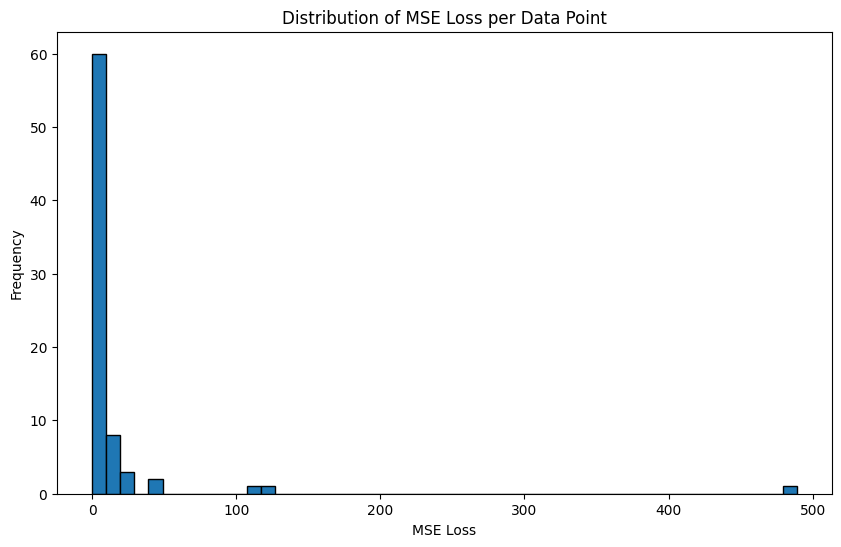

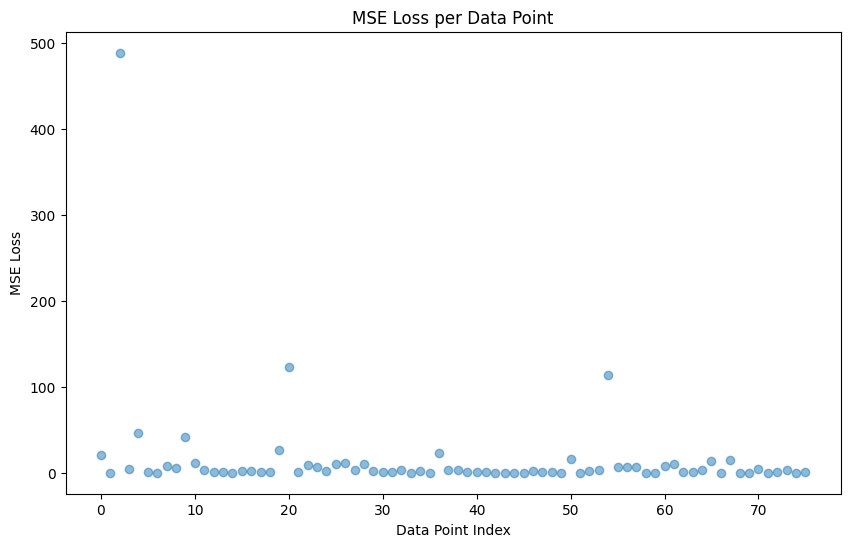

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_mse_per_datapoint(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1)

def analyze_mse_loss(X_test, y_test, best_model):
    y_pred = best_model.predict(X_test)
    mse_per_datapoint = calculate_mse_per_datapoint(y_test, y_pred)
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Index': np.arange(len(y_test)),
        'MSE': mse_per_datapoint,
        'True': y_test.tolist(),
        'Predicted': y_pred.tolist()
    })
    
    # Sort the DataFrame by MSE
    results_df = results_df.sort_values(by='MSE', ascending=False)
    
    # Display the top 5 data points with the highest MSE
    print("Top 5 data points with the highest MSE:")
    print(results_df.head())
    
    # Display the top 5 data points with the lowest MSE
    print("\nTop 5 data points with the lowest MSE:")
    print(results_df.tail())
    
    # Plot the MSE distribution
    plt.figure(figsize=(10, 6))
    plt.hist(mse_per_datapoint, bins=50, edgecolor='k')
    plt.title('Distribution of MSE Loss per Data Point')
    plt.xlabel('MSE Loss')
    plt.ylabel('Frequency')
    plt.savefig('figures/3/q3_6_mse_distribution.png')
    plt.show()
    
    # Plot the data points with the highest and lowest MSE
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['Index'], results_df['MSE'], alpha=0.5)
    plt.title('MSE Loss per Data Point')
    plt.xlabel('Data Point Index')
    plt.ylabel('MSE Loss')
    plt.savefig('figures/3/q3_6_mse_per_datapoint.png')
    plt.show()

    return results_df

# Analyze the MSE loss for each data point in the test dataset
results_df = analyze_mse_loss(X_test_standardized, y_test, best_model)



Epoch 100/1000, Loss: 0.1716
Early stopping at epoch 114
Early stopping at epoch 20


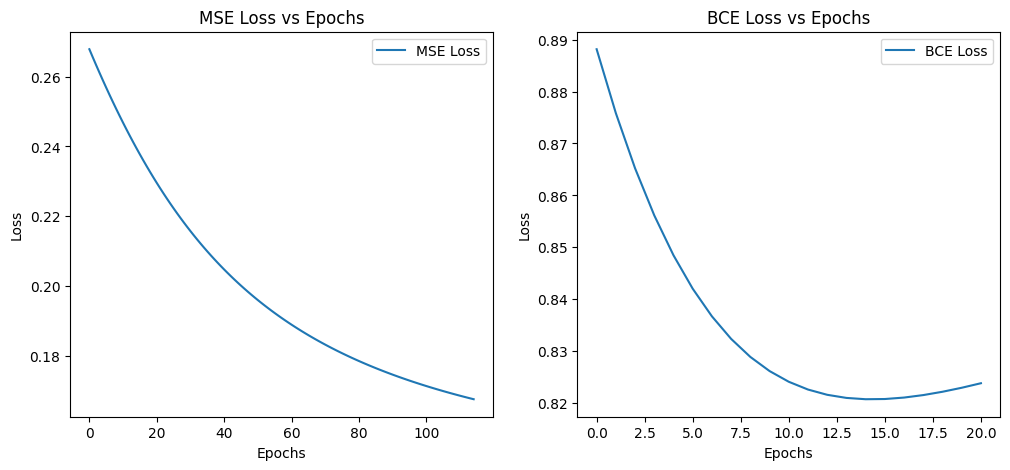

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the MLPClassifier_3 class for binary classification
class MLPClassifier_3:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', 
                 learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd', patience=5, min_delta=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.patience = patience
        self.min_delta = min_delta

        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

        self.set_activation(activation)

    def set_activation(self, activation):
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        elif activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == 'linear':
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative
        else:
            raise ValueError("Unsupported activation function")

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -709, 709)))

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def linear_derivative(x):
        return np.ones_like(x)

    def forward_propagation(self, X):
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activation(z) if i < len(self.weights) - 1 else self.sigmoid(z)
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y, loss_function='bce'):
        m = X.shape[0]
        if loss_function == 'bce':
            delta = self.layer_outputs[-1] - y.reshape(-1, 1)
        elif loss_function == 'mse':
            delta = (self.layer_outputs[-1] - y.reshape(-1, 1)) * self.sigmoid_derivative(self.layer_outputs[-1])
        gradients = []
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dW, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(self.layer_outputs[i])
        return list(reversed(gradients))

    def update_parameters(self, gradients):
        for i, (dW, db) in enumerate(gradients):
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, X_val=None, y_val=None, loss_function='bce'):
        self.losses = []
        self.val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        y = y.to_numpy()  # Convert to numpy array
        if y_val is not None:
            y_val = y_val.to_numpy()  # Convert to numpy array

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                y_pred = self.forward_propagation(batch_X)
                gradients = self.backward_propagation(batch_X, batch_y, loss_function)
                self.update_parameters(gradients)
            
            loss = self.compute_loss(X, y, loss_function)
            self.losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val, loss_function)
                self.val_losses.append(val_loss)
                
                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward_propagation(X)

    def compute_loss(self, X, y, loss_function='bce'):
        y_pred = self.forward_propagation(X)
        if loss_function == 'bce':
            return -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        elif loss_function == 'mse':
            return np.mean((y_pred - y.reshape(-1, 1))**2)

# Load the Pima Indians Diabetes dataset
diabetes_df = pd.read_csv('../../data/external/diabetes.csv')

# Preprocess the dataset
X_diabetes = diabetes_df.drop('Outcome', axis=1)
y_diabetes = diabetes_df['Outcome']

X_train_d, X_temp_d, y_train_d, y_temp_d = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=42)
X_val_d, X_test_d, y_val_d, y_test_d = train_test_split(X_temp_d, y_temp_d, test_size=0.5, random_state=42)

# Standardize the data
scaler_d = StandardScaler()
X_train_d_standardized = scaler_d.fit_transform(X_train_d)
X_val_d_standardized = scaler_d.transform(X_val_d)
X_test_d_standardized = scaler_d.transform(X_test_d)

# Convert back to DataFrame for consistency
X_train_d = pd.DataFrame(X_train_d_standardized, columns=X_diabetes.columns)
X_val_d = pd.DataFrame(X_val_d_standardized, columns=X_diabetes.columns)
X_test_d = pd.DataFrame(X_test_d_standardized, columns=X_diabetes.columns)

# Train models with MSE and BCE loss
model_mse = MLPClassifier_3(input_size=X_train_d.shape[1], hidden_sizes=[], output_size=1, activation='linear', epochs=1000)
model_bce = MLPClassifier_3(input_size=X_train_d.shape[1], hidden_sizes=[], output_size=1, activation='linear', epochs=1000)

model_mse.fit(X_train_d, y_train_d, X_val_d, y_val_d, loss_function='mse')
model_bce.fit(X_train_d, y_train_d, X_val_d, y_val_d, loss_function='bce')

# Plot the loss vs epochs for both models
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model_mse.losses, label='MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_bce.losses, label='BCE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BCE Loss vs Epochs')
plt.legend()
plt.savefig('figures/3/q_3_5.png')
plt.show()

# 3. Observations and Differences
We can observe the convergence plots and note down the differences. Typically, BCE loss is more suitable for binary classification tasks as it aligns better with the probabilistic interpretation of binary outcomes. MSE loss might not converge as well and could lead to different convergence behavior.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

class MLP_combined:
    def __init__(self, input_size, hidden_sizes, output_size, task='regression', activation='relu', 
                 learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd', patience=5, min_delta=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.task = task
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.patience = patience
        self.min_delta = min_delta

        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

        self.set_activation(activation)

    def set_activation(self, activation):
        if activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        elif activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == 'linear':
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative
        else:
            raise ValueError("Unsupported activation function")

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -709, 709)))

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def linear_derivative(x):
        return np.ones_like(x)

    def forward_propagation(self, X):
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            if i < len(self.weights) - 1:
                a = self.activation(z)
            else:
                if self.task == 'classification':
                    a = self.sigmoid(z)
                else:
                    a = z
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y):
        m = X.shape[0]
        if self.task == 'classification':
            delta = self.layer_outputs[-1] - y.reshape(-1, 1)
        else:
            delta = self.layer_outputs[-1] - y.reshape(-1, 1)
        gradients = []
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dW, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(self.layer_outputs[i])
        return list(reversed(gradients))

    def update_parameters(self, gradients):
        for i, (dW, db) in enumerate(gradients):
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, X_val=None, y_val=None):
        self.losses = []
        self.val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        y = y.to_numpy()  # Convert to numpy array
        if y_val is not None:
            y_val = y_val.to_numpy()  # Convert to numpy array

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                y_pred = self.forward_propagation(batch_X)
                gradients = self.backward_propagation(batch_X, batch_y)
                self.update_parameters(gradients)
            
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val)
                self.val_losses.append(val_loss)
                
                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward_propagation(X)

    def compute_loss(self, X, y):
        y_pred = self.forward_propagation(X)
        if self.task == 'classification':
            return -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        else:
            return np.mean((y_pred - y.reshape(-1, 1))**2)

# Load the Pima Indians Diabetes dataset for classification
diabetes_df = pd.read_csv('../../data/external/diabetes.csv')

# Preprocess the dataset
X_diabetes = diabetes_df.drop('Outcome', axis=1)
y_diabetes = diabetes_df['Outcome']

X_train_d, X_temp_d, y_train_d, y_temp_d = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=42)
X_val_d, X_test_d, y_val_d, y_test_d = train_test_split(X_temp_d, y_temp_d, test_size=0.5, random_state=42)

# Standardize the data
scaler_d = StandardScaler()
X_train_d_standardized = scaler_d.fit_transform(X_train_d)
X_val_d_standardized = scaler_d.transform(X_val_d)
X_test_d_standardized = scaler_d.transform(X_test_d)

# Convert back to DataFrame for consistency
X_train_d = pd.DataFrame(X_train_d_standardized, columns=X_diabetes.columns)
X_val_d = pd.DataFrame(X_val_d_standardized, columns=X_diabetes.columns)
X_test_d = pd.DataFrame(X_test_d_standardized, columns=X_diabetes.columns)

# Train model for classification
model_classification = MLP_combined(input_size=X_train_d.shape[1], hidden_sizes=[], output_size=1, task='classification', activation='linear', epochs=1000)
model_classification.fit(X_train_d, y_train_d, X_val_d, y_val_d)

# Evaluate classification model
y_pred_classification = model_classification.predict(X_test_d)
y_pred_classification_binary = (y_pred_classification > 0.5).astype(int)
accuracy = accuracy_score(y_test_d, y_pred_classification_binary)
print(f"Classification Accuracy: {accuracy:.4f}")
print("\n" + "="*50 + "\n")

# Load the Housing dataset for regression
housing_df = pd.read_csv('../../data/external/HousingData.csv')

# Plot the distribution of the target variable (MEDV)
medv_values = housing_df['MEDV']

# Handle NaN values by filling them with the mean of the column
housing_df.fillna(housing_df.mean(), inplace=True)

# Ensure no NaN values are present
assert not housing_df.isnull().values.any(), "There are still NaN values in the dataset"

# Preprocess the dataset
X_housing = housing_df.drop('MEDV', axis=1)
y_housing = housing_df['MEDV']

# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train_h, X_temp_h, y_train_h, y_temp_h = train_test_split(X_housing, y_housing, test_size=0.3, random_state=42)
X_val_h, X_test_h, y_val_h, y_test_h = train_test_split(X_temp_h, y_temp_h, test_size=0.5, random_state=42)

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_train_h_imputed = imputer.fit_transform(X_train_h)
X_val_h_imputed = imputer.transform(X_val_h)
X_test_h_imputed = imputer.transform(X_test_h)

# Normalize the features using Min-Max scaling
min_max_scaler = MinMaxScaler()
X_train_h_normalized = min_max_scaler.fit_transform(X_train_h_imputed)
X_val_h_normalized = min_max_scaler.transform(X_val_h_imputed)
X_test_h_normalized = min_max_scaler.transform(X_test_h_imputed)

# Standardize the features to have mean=0 and std=1 using Z-score scaling
standard_scaler = StandardScaler()
X_train_h_standardized = standard_scaler.fit_transform(X_train_h_imputed)
X_val_h_standardized = standard_scaler.transform(X_val_h_imputed)
X_test_h_standardized = standard_scaler.transform(X_test_h_imputed)

# Convert back to DataFrame for consistency
X_train_h = pd.DataFrame(X_train_h_standardized, columns=X_housing.columns)
X_val_h = pd.DataFrame(X_val_h_standardized, columns=X_housing.columns)
X_test_h = pd.DataFrame(X_test_h_standardized, columns=X_housing.columns)

# Train model for regression
model_regression = MLP_combined(input_size=X_train_h.shape[1], hidden_sizes=[], output_size=1, task='regression', activation='linear', epochs=1000)
model_regression.fit(X_train_h, y_train_h, X_val_h, y_val_h)

# Evaluate regression model
y_pred_regression = model_regression.predict(X_test_h)
mse = mean_squared_error(y_test_h, y_pred_regression)
mae = mean_absolute_error(y_test_h, y_pred_regression)
print(f"Regression MSE: {mse:.4f}")
print(f"Regression MAE: {mae:.4f}")



Early stopping at epoch 20
Classification Accuracy: 0.6810


Epoch 100/1000, Loss: 23.6294
Epoch 200/1000, Loss: 23.5499
Epoch 300/1000, Loss: 23.5393
Epoch 400/1000, Loss: 23.5375
Epoch 500/1000, Loss: 23.5373
Early stopping at epoch 511
Regression MSE: 28.3368
Regression MAE: 3.5249
